<a href="https://colab.research.google.com/github/yashtiwari22/lung_cancer_detection/blob/main/lung_cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings

# Suppressing warnings

In [ ]:
warnings.filterwarnings('ignore')

# Mounting Google Drive to access data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setting up paths and classes

In [ ]:
path = '/content/drive/MyDrive/lung_image_sets'
classes = os.listdir(path)
classes

['lung_aca', 'lung_n', 'lung_scc']

# Visualizing sample images from each class

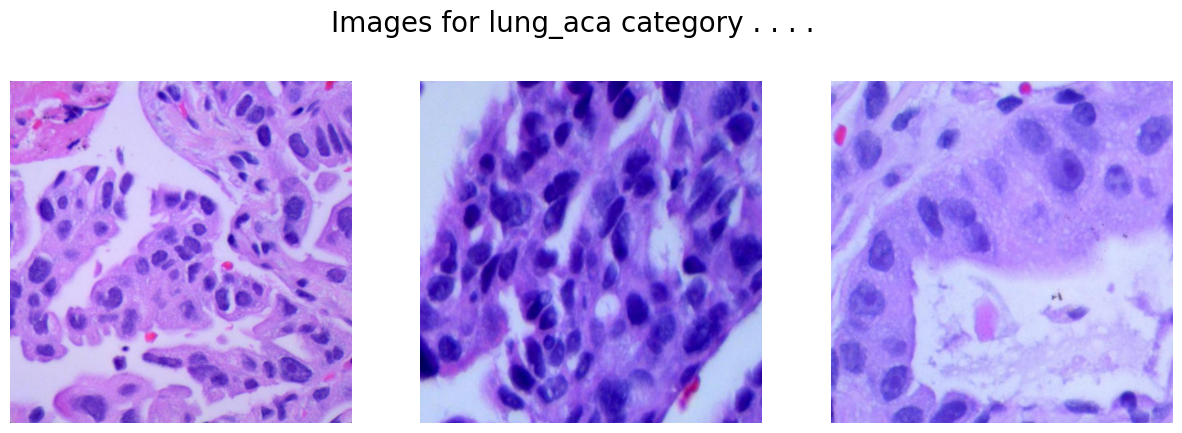

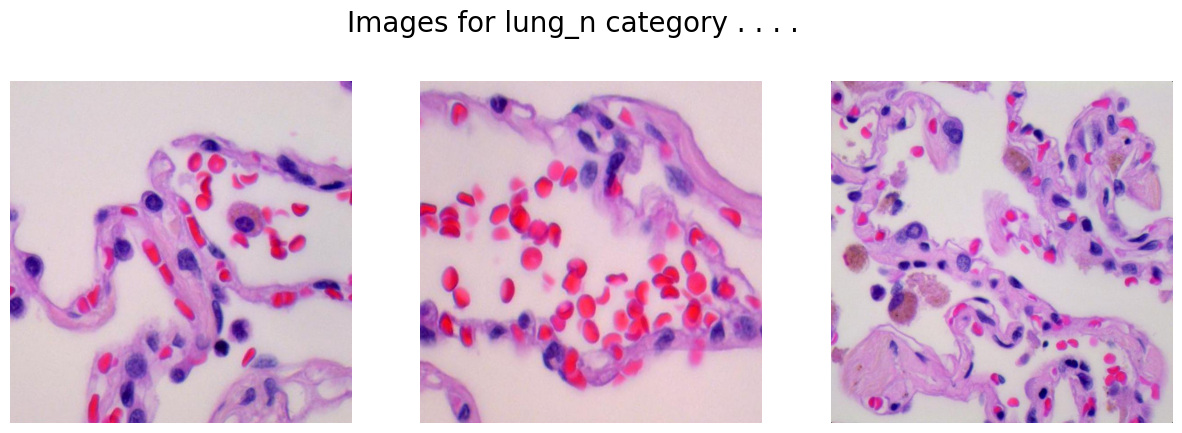

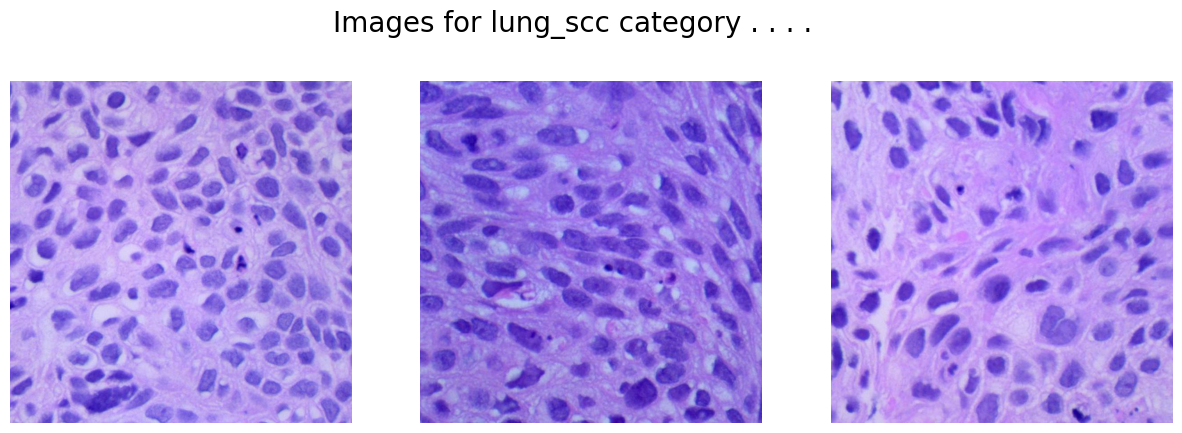

In [ ]:


for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

# Setting up constants and variables for data preprocessing

In [ ]:

IMG_SIZE = 150
SPLIT = 0.2
EPOCHS = 8
BATCH_SIZE = 32

# Preprocessing images and labels

In [ ]:
X = []
Y = []

for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')

  for image in images:
    img = cv2.imread(image)

    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

# Splitting data into training and validation sets

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
                                                  test_size = SPLIT,
                                                  random_state = 2022)
print(X_train.shape, X_val.shape)

(12000, 150, 150, 3) (3000, 150, 150, 3)


# Defining CNN model architecture

In [ ]:
model = keras.models.Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(IMG_SIZE,
                               IMG_SIZE,
                               3),
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 128)       0

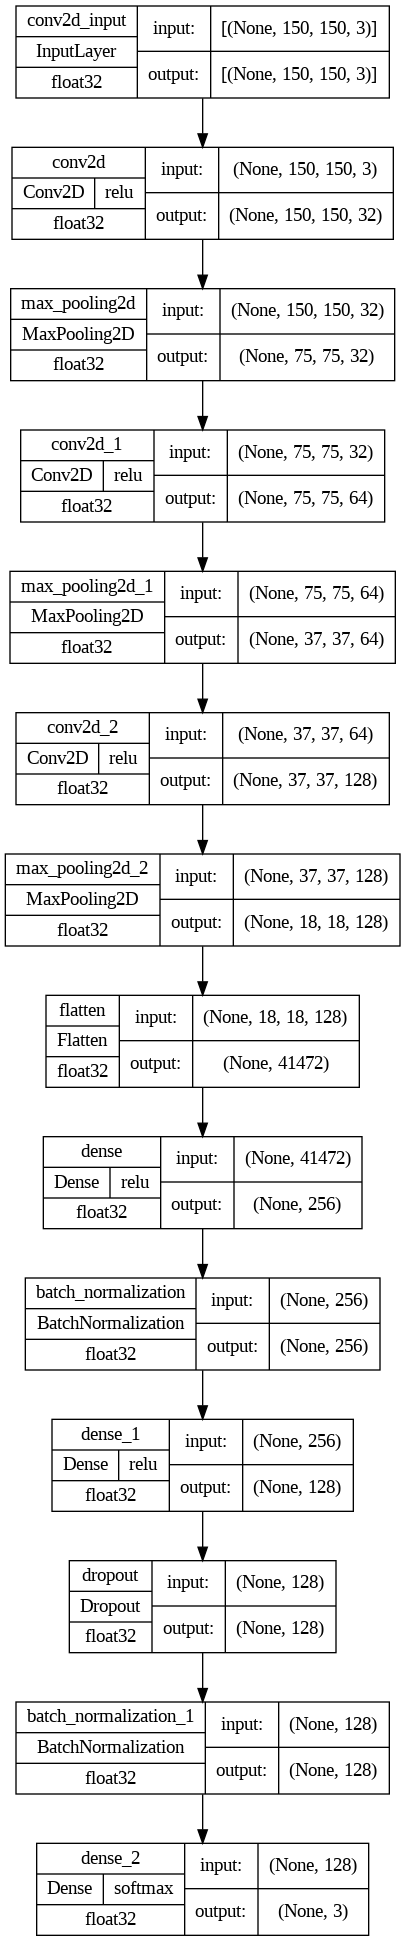

In [ ]:
keras.utils.plot_model(
	model,
	show_shapes = True,
	show_dtype = True,
	show_layer_activations = True
)


In [ ]:
model.compile(
	optimizer = 'adam',
	loss = 'categorical_crossentropy',
	metrics = ['accuracy']
)


# Defining callbacks for early stopping and learning rate reduction

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_accuracy') > 0.90:
			print('\n Validation accuracy has reached upto \
					90% so, stopping further training.')
			self.model.stop_training = True


es = EarlyStopping(patience=3,
				monitor='val_accuracy',
				restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
					patience=2,
					factor=0.5,
					verbose=1)


# Training the model

In [ ]:
history = model.fit(X_train, Y_train,
					validation_data = (X_val, Y_val),
					batch_size = BATCH_SIZE,
					epochs = EPOCHS,
					verbose = 1,
					callbacks = [es, lr, myCallback()])


Epoch 1/8
375/375 [==============================] - 873s 2s/step - loss: 0.3750 - accuracy: 0.8511 - val_loss: 8.8149 - val_accuracy: 0.4373 - lr: 0.0010
Epoch 2/8
375/375 [==============================] - 887s 2s/step - loss: 0.2392 - accuracy: 0.9028 - val_loss: 1.2354 - val_accuracy: 0.6567 - lr: 0.0010
Epoch 3/8
375/375 [==============================] - 897s 2s/step - loss: 0.2050 - accuracy: 0.9170 - val_loss: 1.4064 - val_accuracy: 0.5287 - lr: 0.0010
Epoch 4/8
375/375 [==============================] - 891s 2s/step - loss: 0.1832 - accuracy: 0.9277 - val_loss: 0.6537 - val_accuracy: 0.7880 - lr: 0.0010
Epoch 5/8
375/375 [==============================] - 855s 2s/step - loss: 0.1554 - accuracy: 0.9382 - val_loss: 7.4874 - val_accuracy: 0.3583 - lr: 0.0010
Epoch 6/8
375/375 [==============================] - ETA: 0s - loss: 0.1400 - accuracy: 0.9452
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
375/375 [==============================] - 872s 2s/ste

# Plotting training history

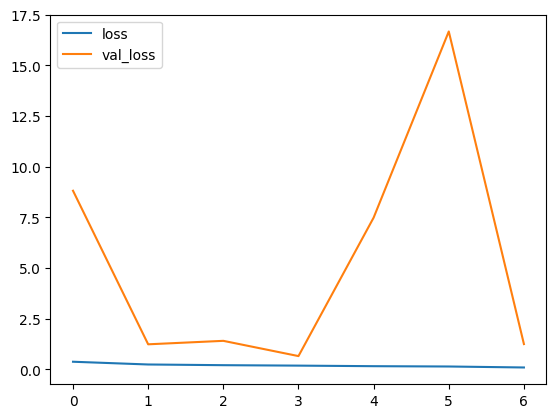

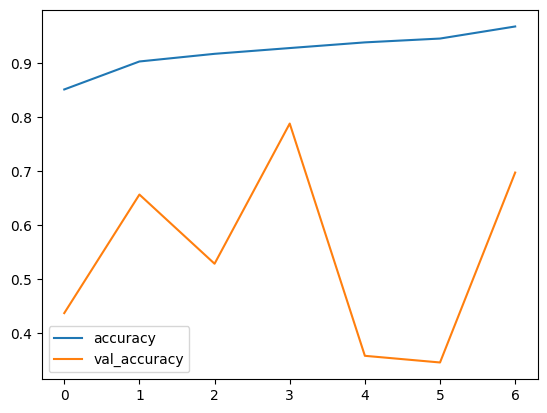

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()


# Making predictions and evaluating the model

In [ ]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)


94/94 [==============================] - 56s 595ms/step


In [ ]:
metrics.confusion_matrix(Y_val, Y_pred)


array([[420, 448, 119],
       [  0, 977,   0],
       [ 44,  25, 967]])

In [ ]:
print(metrics.classification_report(Y_val, Y_pred,
									target_names=classes))


              precision    recall  f1-score   support

    lung_aca       0.91      0.43      0.58       987
      lung_n       0.67      1.00      0.81       977
    lung_scc       0.89      0.93      0.91      1036

    accuracy                           0.79      3000
   macro avg       0.82      0.79      0.77      3000
weighted avg       0.82      0.79      0.77      3000

